In this notebook we explore how to do linear regression using Bayesian inference and a Metropolis MCMC sampler.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import metropolis

np.random.seed(123) # For reproducing random results

Polynomial function of the form $y = a_0 + a_1 x + \epsilon$ where $\epsilon$ is some noise model.

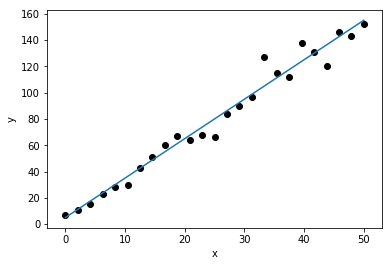

In [2]:
a = [5, 3]
x = np.linspace(0, 50, num=25)

line = lambda a, x: a[0] + a[1]*x
y_true = line(a, x)
y_obs = np.random.poisson(y_true)

plt.plot(x, y_true);
plt.scatter(x, y_obs, c='k');
plt.xlabel('x'); plt.ylabel('y');

Now set up the prior, first guess of the prior, likelihood, number of iterations, and the target function (product of the prior and likelihoods).

In [3]:
def gaus_likelihood(f, p, x, y):
    """ 
    Gaussian likelihood. 
    ARUMENTS:
    f : the function that transforms (p, x) -> y_model 
        for a choice of prior variables.
    p : parameters for the model.
    x : independent variable.
    y : observed data.    
    """
    y_model = f(p, x)
    C = (np.std(y)*np.sqrt(2*np.pi))
    exp_args = sum([(y_i - y_model_i)**2 
                for (y_i, y_model_i) in zip(y, y_model)])
    return np.exp(-0.5*exp_args/np.std(y_model)**2)/C

In [18]:
prior = [ 
        scipy.stats.norm(loc=0, scale=50),
        scipy.stats.norm(loc=0, scale=20) 
        ]
# Initial guess for the prior variables.
start = [prior_i.rvs() for prior_i in prior]
# Number of iterations
n_iter = 20000
n_burn = n_iter//10

def target(p):
    """ Target function which is the product of the liekihood and prior """
    l = gaus_likelihood(line, p, x, y_obs)
    prior_prob = np.prod([prior_i.pdf(p_i) for prior_i, p_i in zip(prior, p)])
    return l*prior_prob

def proposal(p, proposal_jump=[1, 1]):
    """ 
    Generate a new proposal, or "guess" for the MCMC to try next. 
    The new proposed value is picked from a Normal, centered on 
    the old value given by p. The proposal_jump array specifies 
    the standard deviation of the possible jumps from the prior
    parameter value.
    """
    new_vals = np.array([scipy.stats.norm(loc=p_i, scale=jump_i).rvs() 
                    for p_i, jump_i in zip(p, proposal_jump)])    
    return new_vals

Now run the MCMC sampler.

In [19]:
trace = metropolis.metropolis(start, target, proposal, n_iter, nburn=n_burn)

100% (20000 of 20000) |##################| Elapsed Time: 0:00:49 Time:  0:00:49


Now visualize the posterior distributions with the true values shown with black vertical line.

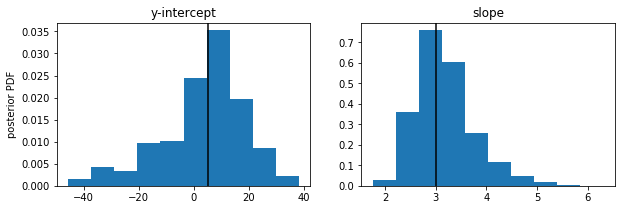

In [32]:
_, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].hist(trace[:, 0], density=True); ax[0].axvline(a[0], c='k'); ax[0].set_title('y-intercept');
ax[1].hist(trace[:, 1], density=True); ax[1].axvline(a[1], c='k'); ax[1].set_title('slope')
ax[0].set_ylabel('posterior PDF');

Now calculate the statistics on the trace plots i.e. 2.5, 50 (median), and 97.5 percentiles. Put into a DataFrame to make a pritty table.

In [42]:
percentiles = np.nan*np.zeros((len(a), 4))

for i, trace_i in enumerate(trace.T):
    percentiles[i, :-1] = np.percentile(trace_i, [2.5, 50, 97.5])
    percentiles[i, -1] = a[i]
df = pd.DataFrame(data=percentiles, columns=['2.5%', '50%', '97.5%', 'true'], 
                  index=[f'a{i}' for i in range(len(a))])

In [44]:
df

,2.5%,50%,97.5%,true
a0,-33.631413,6.095269,28.533616,5.0
a1,2.301819,3.085530,4.583322,3.0
